# Machine Learning with Raman spectrocopy - Binary Classification with Neuron Networks

Inspired by this paper (Paper of reference: https://opg.optica.org/boe/fulltext.cfm?uri=boe-9-10-4998&id=398623), the goal of this project is to analyze the Raman information acquired with portable Raman spectrometer for in-vitro and rapid identification of pateints having Type 2 diabetes mellitus (DM2). Data being analyzed are also public available form the publisher's website

## Project Introduction

The project develops a **neural network** to classify patients as diabetic or non-diabetic based on **Raman spectroscopy** data. After preprocessing the spectra with area normalization and standardization, a model incorporating dropout layers achieved a **validation accuracy of 93.5%**.

In [ ]:
# Get predefined helper functions
!wget https://raw.githubusercontent.com/Eddiesunset0121/Diabetes-Raman-Classification/refs/heads/main/helper_function.py

--2025-08-15 01:47:30--  https://raw.githubusercontent.com/Eddiesunset0121/Diabetes-Raman-Classification/refs/heads/main/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9738 (9.5K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]   9.51K  --.-KB/s    in 0s      

2025-08-15 01:47:30 (108 MB/s) - ‘helper_function.py’ saved [9738/9738]



In [ ]:
import tensorflow as tf
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from helper_function import plot_loss_curves, make_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Data preprocessing / EDA

In [ ]:
# Loading dataset
data = pd.read_csv("Raman_dataset_800_1800.csv")
data.head()

,DBM,position,ramanshift_800,ramanshift_801,ramanshift_802,ramanshift_803,ramanshift_804,ramanshift_805,ramanshift_806,ramanshift_807,...,ramanshift_1791,ramanshift_1792,ramanshift_1793,ramanshift_1794,ramanshift_1795,ramanshift_1796,ramanshift_1797,ramanshift_1798,ramanshift_1799,ramanshift_1800
0,1,earlobes,191.19,195.94,197.02,194.77,192.74,191.22,190.19,195.59,...,49.93,47.62,48.35,51.60,53.38,51.30,50.60,50.60,50.73,50.42
1,1,earlobes,175.02,183.28,189.84,194.87,195.26,184.74,175.34,180.02,...,52.18,49.23,45.81,48.12,51.24,55.39,55.35,53.16,51.45,51.40
2,1,earlobes,120.81,122.16,124.74,128.42,129.15,122.95,117.39,120.00,...,39.35,34.85,30.10,29.00,29.13,31.57,35.55,40.04,33.69,30.23
3,1,earlobes,307.79,313.47,317.82,320.96,321.38,315.39,310.07,313.29,...,66.37,67.09,68.10,66.16,65.64,68.90,68.86,67.17,67.48,68.14
4,1,earlobes,67.17,64.48,64.90,68.13,69.57,66.78,64.21,64.30,...,19.98,17.90,19.12,19.31,19.87,21.46,21.27,20.16,18.32,18.53


DBM
1    44
0    36
Name: count, dtype: int64


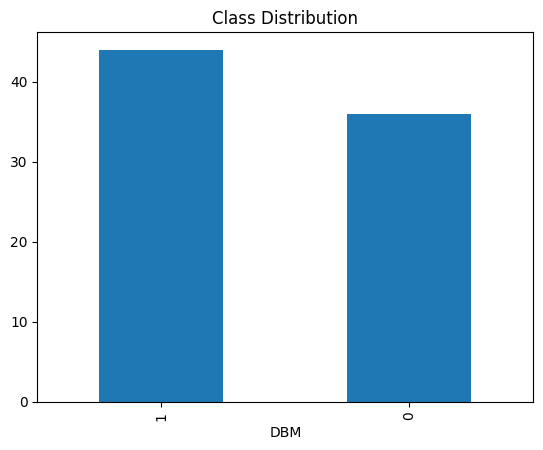

In [ ]:
print(data['DBM'].value_counts())
data['DBM'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

The class of 1 (with diabetes) and 0 (without diaberes) are not balanced, therefore, it's a good choice to use "statify=y" in train_test_split to maintain ratio of two classes in both training and test datasets

DBM column:
* 0: without diabetes
* 1: with diabetes

position: the body part where Raman spectrum is measured

ramanshift_XX: the wavenumber of Raman signal measured

In [ ]:
# Prepare predictor and labels
X = data.drop(columns=["DBM", "position"])
y = data["DBM"]

# Prepare training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

# Check the length after seperation
len(X_train), len(X_test), len(y_train), len(y_test)

(64, 16, 64, 16)

The 800-1800 cm⁻¹ range is the biochemical fingerprint region, containing distinct peaks from proteins, lipids, and carbohydrates that are relevant to metabolic changes in diabetes. This focused window is crucial as it maximizes the relevant biological information while avoiding the strong, interfering signal from water found at higher wavenumbers.

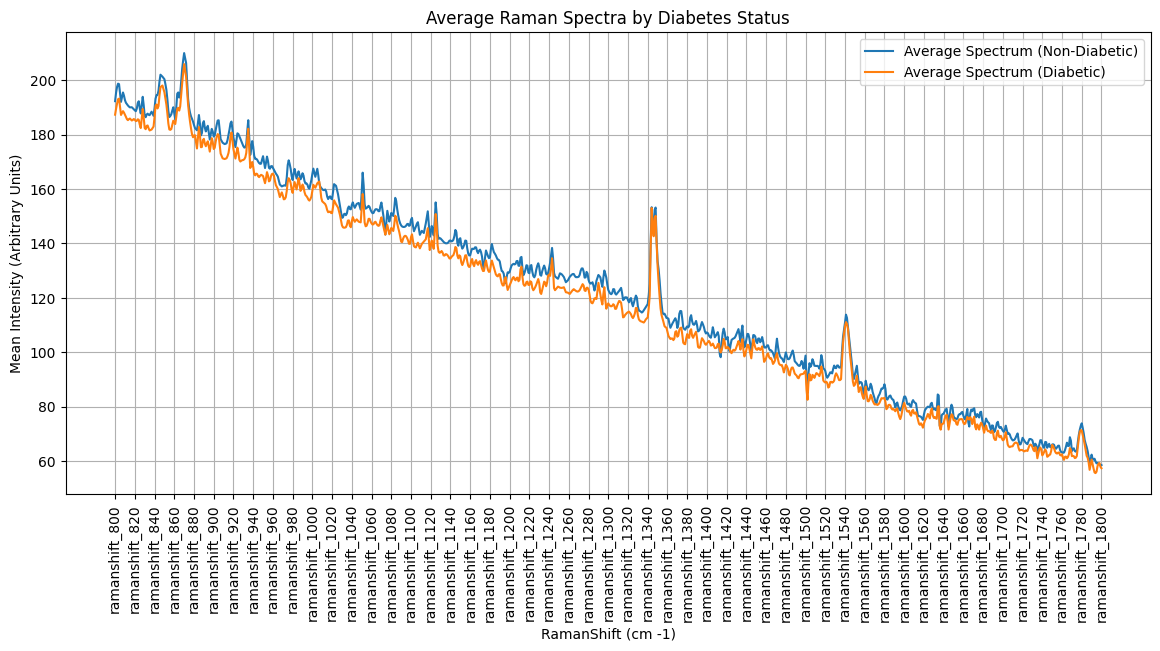

In [ ]:
# Get the Ramanshift column names (they are the features)
raman_shifts = X.columns

plt.figure(figsize=(14, 6))

# Calculate and plot mean spectrum for non-diabetic (DBM=0)
plt.plot(raman_shifts, X[y==0].mean(), label='Average Spectrum (Non-Diabetic)')

# Calculate and plot mean spectrum for diabetic (DBM=1)
plt.plot(raman_shifts, X[y==1].mean(), label='Average Spectrum (Diabetic)')

plt.title('Average Raman Spectra by Diabetes Status')
plt.xlabel('RamanShift (cm -1)')
plt.ylabel('Mean Intensity (Arbitrary Units)')
plt.xticks(ticks=raman_shifts[::20], rotation=90)
plt.legend()
plt.grid(True)
plt.show()

After the spetra (diabetic vs, non-diabetic) are averaged, peak differences can be observed around 1350 cm-1 and 1380 cm-1, the difference, thought not substantial, can still be potentially leveraged by machine learning model for classification.

In [ ]:
X_train.values

array([[ 63.44,  66.67,  67.44, ...,  13.07,  16.13,  17.52],
       [178.14, 184.69, 187.04, ...,  59.86,  62.43,  64.1 ],
       [174.53, 180.27, 183.99, ...,  59.76,  57.92,  56.75],
       ...,
       [193.42, 201.41, 204.82, ...,  62.03,  63.25,  64.38],
       [422.78, 427.56, 430.97, ..., 159.6 , 156.95, 155.29],
       [280.35, 281.81, 283.27, ...,  96.97,  95.75,  95.77]])

In [ ]:
# Define a function for area normalization
def area_norm(data):
  area = np.sum(data.values, axis = 1)
  return data.divide(area, axis = 0)

**Area normalization:** Corrects for sample-to-sample variations


Difference in aquisition time of detectors between each measurements will gives slightly different overall peak intensity, therefore correcting peak intensities between experiments using total area under a spectrum for normalization is necessary, other fluctuations include laser intensity and sample concentration...the final area of a spectrum is normalized to 1.

In [ ]:
# Area normalization to reduce variation between measurements, for example,
X_train_area_norm = area_norm(X_train)
X_test_area_norm = area_norm(X_test)

In [ ]:
X_train_area_norm.head()

,ramanshift_800,ramanshift_801,ramanshift_802,ramanshift_803,ramanshift_804,ramanshift_805,ramanshift_806,ramanshift_807,ramanshift_808,ramanshift_809,...,ramanshift_1791,ramanshift_1792,ramanshift_1793,ramanshift_1794,ramanshift_1795,ramanshift_1796,ramanshift_1797,ramanshift_1798,ramanshift_1799,ramanshift_1800
47,0.001505,0.001581,0.001600,0.001566,0.001535,0.001511,0.001490,0.001501,0.001512,0.001522,...,0.000326,0.000355,0.000289,0.000279,0.000278,0.000287,0.000297,0.000310,0.000383,0.000416
74,0.001489,0.001544,0.001563,0.001551,0.001538,0.001521,0.001506,0.001530,0.001553,0.001526,...,0.000565,0.000560,0.000557,0.000543,0.000535,0.000540,0.000525,0.000500,0.000522,0.000536
32,0.001524,0.001575,0.001607,0.001624,0.001609,0.001520,0.001440,0.001475,0.001509,0.001505,...,0.000524,0.000525,0.000511,0.000528,0.000532,0.000501,0.000504,0.000522,0.000506,0.000496
12,0.001603,0.001696,0.001763,0.001805,0.001791,0.001645,0.001514,0.001588,0.001661,0.001643,...,0.000423,0.000412,0.000338,0.000360,0.000368,0.000328,0.000356,0.000418,0.000397,0.000392
5,0.002058,0.001909,0.001842,0.001851,0.001897,0.002034,0.002150,0.001996,0.001843,0.001897,...,0.000227,0.000213,0.000230,0.000197,0.000220,0.000383,0.000377,0.000285,0.000246,0.000230


**StandardScaler on intensity:** Corrects for feature-to-feature variations across a single spectrum

**StandardScaler** is a way to standardize the feature values for the model without destroying the intrinsic structure (the relative peak heights and shapes) of each individual Raman spectrum.

In contrast, **MinMaxScaler** scales intensity to the range of [0,1] and is prone to outliers, causing the model to potentially losing important features if other feattures are scaled down due to an outlier.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_area_norm)

StandardScaler()

In [ ]:
X_train_final = scaler.transform(X_train_area_norm)
X_test_final = scaler.transform(X_test_area_norm)

In [ ]:
# StandardScaler function returns a NumPy array by default
X_train_final, X_train_final.shape

(array([[-0.4098975 , -0.23786521, -0.25019023, ..., -1.19539367,
         -0.62644548, -0.31818051],
        [-0.46731539, -0.44734005, -0.52609923, ...,  0.46831951,
          0.79209793,  0.97464765],
        [-0.33781736, -0.27555286, -0.19323863, ...,  0.65733175,
          0.62983251,  0.54340917],
        ...,
        [-0.30966081, -0.15925807, -0.07600912, ...,  0.3897263 ,
          0.58010622,  0.69705036],
        [-0.59164697, -0.85051866, -1.13767297, ...,  0.89586998,
          0.97866885,  0.96005022],
        [-0.299181  , -0.45160391, -0.62074271, ...,  0.73570112,
          0.81684756,  0.85185695]]),
 (64, 1001))

1. Fit (Learn the Rules) 🧠
The .fit() method is the learning step. The scaler analyzes your training data (X_train_area_norm) to calculate the parameters it needs for the transformation (in the case of StandardScaler, it's the mean and standard deviation of each feature). This step should only ever be done on the training data. This ensures that no information from your test set can influence the transformation rules.

2. Transform (Apply the Rules)
It takes the rules learned during the fit step and applies them to whatever data provided. Must apply this same transformation to both training data and test data to ensure they are processed in the exact same way.

## Create a base model

In [ ]:
# Train a baseline model
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_final, y_train)

# Evaluate the baseline
baseline_preds = baseline_model.predict(X_test_final)
baseline_accuracy = accuracy_score(y_test, baseline_preds)
print(f"Baseline Logistic Regression Accuracy: {baseline_accuracy:.4f}")

Baseline Logistic Regression Accuracy: 0.8750


The simple Logistic Regression model achieved a strong baseline accuracy of 87.5%. This sets a benchmark that the neural network models must outperform to justify their increased complexity

## Building a model with Dense layers

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid"),
])

# Compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
        metrics = ["accuracy"]
        )

# Create a learning_rate scheduler to find optimal learning rate
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/20))

history_1 = model_1.fit(x = X_train_final,
             y = y_train,
             epochs = 100,
             validation_data = (X_test_final, y_test),
             callbacks=[lr_scheduler],
             verbose = 0
             )

In [ ]:
# Learning rate at each epoch
lrs = 1e-4*10**(np.arange(100)/20)
lrs

array([1.00000000e-04, 1.12201845e-04, 1.25892541e-04, 1.41253754e-04,
       1.58489319e-04, 1.77827941e-04, 1.99526231e-04, 2.23872114e-04,
       2.51188643e-04, 2.81838293e-04, 3.16227766e-04, 3.54813389e-04,
       3.98107171e-04, 4.46683592e-04, 5.01187234e-04, 5.62341325e-04,
       6.30957344e-04, 7.07945784e-04, 7.94328235e-04, 8.91250938e-04,
       1.00000000e-03, 1.12201845e-03, 1.25892541e-03, 1.41253754e-03,
       1.58489319e-03, 1.77827941e-03, 1.99526231e-03, 2.23872114e-03,
       2.51188643e-03, 2.81838293e-03, 3.16227766e-03, 3.54813389e-03,
       3.98107171e-03, 4.46683592e-03, 5.01187234e-03, 5.62341325e-03,
       6.30957344e-03, 7.07945784e-03, 7.94328235e-03, 8.91250938e-03,
       1.00000000e-02, 1.12201845e-02, 1.25892541e-02, 1.41253754e-02,
       1.58489319e-02, 1.77827941e-02, 1.99526231e-02, 2.23872114e-02,
       2.51188643e-02, 2.81838293e-02, 3.16227766e-02, 3.54813389e-02,
       3.98107171e-02, 4.46683592e-02, 5.01187234e-02, 5.62341325e-02,
      

Text(0.5, 1.0, 'Loss vs, Learning Rate')

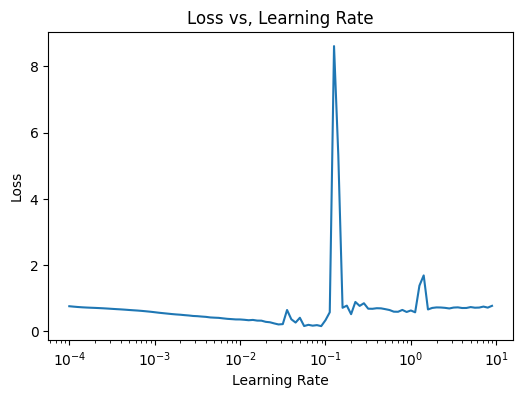

In [ ]:
# Plot loss vs. learning_rate(lrs) to find the optimal learning_rate
plt.figure(figsize = (6,4))
plt.semilogx(lrs, history_1.history['loss'])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss vs, Learning Rate")

In [ ]:
y_pred_1 = model_1.predict(X_test_final)
accuracy_1 = accuracy_score(y_test, tf.round(y_pred_1))
accuracy_1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


0.4375

## Improving model (Learning Rate)

Using the optimal learning rate model_1 -> model_2

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation = "relu"),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation = "relu"),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation = "sigmoid"),
])

# Compile the model
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
        metrics = ["accuracy"]
        )

history_2 = model_2.fit(x = X_train_final,
             y = y_train,
             epochs = 100,
             validation_data = (X_test_final, y_test),
             verbose = 0
             )

In [ ]:
y_pred_2 = model_2.predict(X_test_final)
accuracy_2 = accuracy_score(y_test, tf.round(y_pred_2))
accuracy_2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


0.875

## Improving model (Dropout layer)

Adding Dropout layer model_2 -> model_3

**tf.keras.layers.Dropout()** is a regularization layer in TensorFlow Keras that applies Dropout to the input. This layer is designed to prevent overfitting in neural networks by randomly setting a fraction of input units to zero during each training step. For Dropout(0.4), it means 40% of the neurons are ignored at random for each training batch.

* **Reduces Co-dependency**: It prevents neurons from becoming too dependent on each other. Since any neuron can be "dropped out," the network is forced to learn more robust and redundant features.

* **Encourages Generalization**: By preventing the model from relying on any single neuron or specific pathway, it's less likely to memorize the training data. This forces it to learn a more generalized pattern, which improves its performance on unseen data.

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation = "sigmoid"),
])

# Compile the model
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
        metrics = ["accuracy"]
        )

history_3 = model_3.fit(x = X_train_final,
             y = y_train,
             epochs = 100,
             validation_data = (X_test_final, y_test),
             verbose = 0
             )

In [ ]:
y_pred_3 = model_3.predict(X_test_final)
accuracy_3 = accuracy_score(y_test, tf.round(y_pred_3))
accuracy_3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


0.9375

## Improving model (Early Stopping)

Model 3 has a better val_accuracy (validation accuracy) but a lower accuracy (training accuracy) because it is generalizing better and overfitting less than the other models. This is a very positive result and the primary goal of regularization.

Add early stopping layer to revent from overfitting model_3 -> modle_4

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create a model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation = "sigmoid"),
])

# Compile the model
model_4.compile(loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
        metrics = ["accuracy"])

# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                          patience = 15,
                          restore_best_weights=True)

# Fit the model
history_4 = model_4.fit(x = X_train_final,
             y = y_train,
             epochs = 100,
             validation_data = (X_test_final, y_test),
             callbacks = [early_stopping],
             verbose = 0
             )

In [ ]:
y_pred_4 = model_4.predict(X_test_final)
accuracy_4 = accuracy_score(y_test, tf.round(y_pred_4))
accuracy_4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


0.9375

In [ ]:
y_test.dtype, y_pred_4.dtype

(dtype('int64'), dtype('float32'))

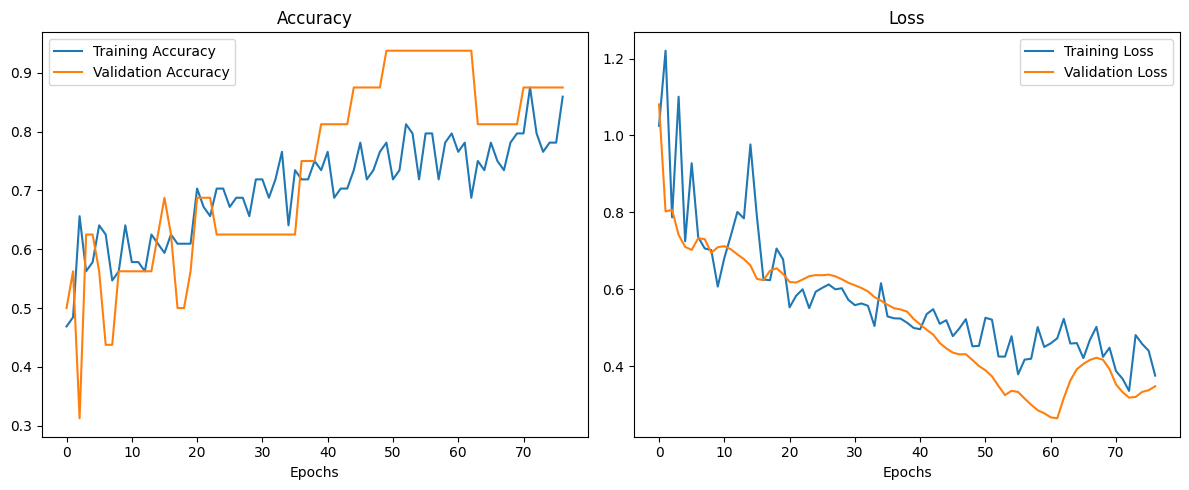

In [ ]:
plot_loss_curves(history_4)

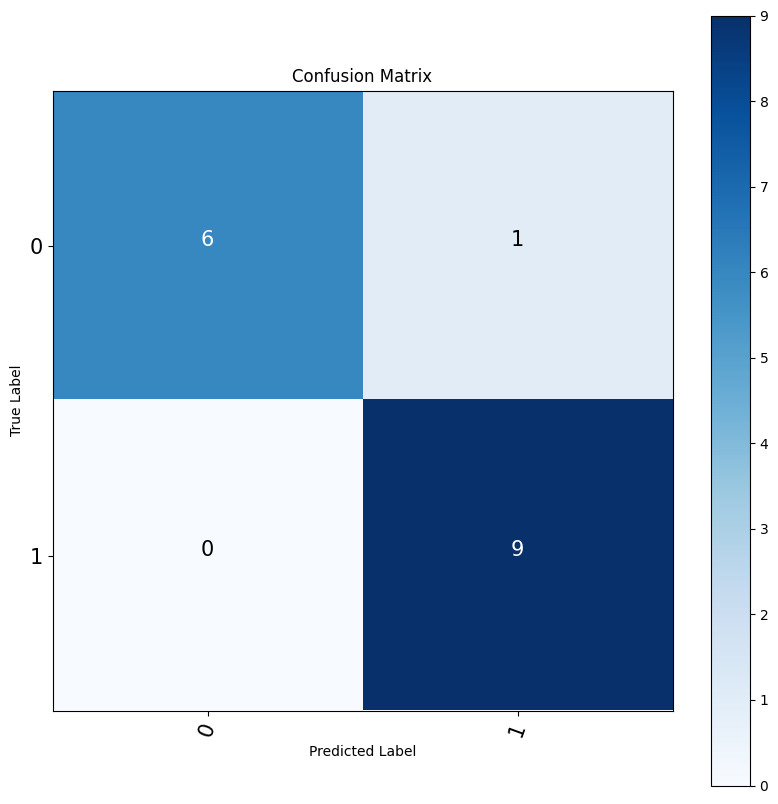

In [ ]:
make_confusion_matrix(y_test, tf.round(y_pred_4))

True negative: 6  / True positive: 8 / False negative: 0 / False positive: 1

In [ ]:
print(classification_report(y_test, tf.round(y_pred_4), target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       1.00      0.86      0.92         7
    Diabetic       0.90      1.00      0.95         9

    accuracy                           0.94        16
   macro avg       0.95      0.93      0.94        16
weighted avg       0.94      0.94      0.94        16



The final model achieved a recall of 1.00 for the 'Diabetic' class. This is a critical result for a medical screening tool, as it means the model correctly identified all diabetic patients in the test set (zero false negatives). The precision of 0.90 indicates that out of all the patients it predicted as diabetic, 90% actually were. This balance is excellent for a screening scenario.

In [ ]:
model_comparison = pd.DataFrame(
                 {'Model': ['baseline', 'model_1', 'model_2', 'model_3', 'model_4'],
                  'Description': ["Logistic Regression", "model_1 = NN"," = model_1 + Tuned LR", "= model_2 + Dropout", "= model_3+ Early Stopping"],
                  'accuracy_val': [baseline_accuracy, accuracy_1, accuracy_2, accuracy_3, accuracy_4]
                 }
                 )

model_comparison

,Model,Description,accuracy_val
0,baseline,Logistic Regression,0.8750
1,model_1,model_1 = NN,0.4375
2,model_2,= model_1 + Tuned LR,0.8750
3,model_3,= model_2 + Dropout,0.9375
4,model_4,= model_3+ Early Stopping,0.9375


## Conclusion

This project demonstrates the potential of using Raman spectroscopy combined with neural networks for a rapid and non-invasive diabetes screening tool. The final model's high accuracy, and particularly its perfect recall for diabetic cases, underscores its potential clinical utility.

* **Effective Preprocessing**: Area normalization and standardization were essential, correcting for measurement variations and preventing feature dominance.

* **Regularization Boosts Performance**: A baseline logistic regression achieved 87.5% accuracy. While a basic neural network underperformed, adding dropout layers was key, increasing validation accuracy to 93.75% by reducing overfitting.

* **High Clinical Potential**: The final model demonstrated strong clinical relevance by achieving a perfect recall of 1.00 for diabetic patients, ensuring no cases were missed in the test set.